In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats.weightstats import ztest as ztest


%matplotlib inline  

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
market_ticker = '^GSPC'
st = 'f'

stime='2021-01-01'
ftime=None

In [4]:
def get_data_from_ticker(tick, stime, ftime, interval='1d'):
    ticker = yf.Ticker(tick)
    # df = ticker.history(start='2021-01-01', end='2022-06-30')
    # df = ticker.history(start='2021-01-01', end='2022-07-26')
    # df = ticker.history(start='2020-01-01', end='2021-01-01')
    # df = ticker.history(start='2022-05-28')
    df = ticker.history(start=stime, end=ftime, interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

gf = pd.DataFrame(get_data_from_ticker(market_ticker, stime, ftime))
sf = pd.DataFrame(get_data_from_ticker(st, stime, ftime))
gf[st] = sf[st]


gf.head(3)

,^GSPC,f
Date,,
2021-01-04 00:00:00-05:00,3700.649902,8.209661
2021-01-05 00:00:00-05:00,3726.860107,8.334924
2021-01-06 00:00:00-05:00,3748.139893,8.518005


In [5]:
def add_percent_update(tick):
    """ date stock's or market's update"""
    gf_copy = gf.copy(deep=True)
    gf_copy = pd.DataFrame(gf_copy.drop(gf.index[0]))
    gf_copy_v = gf_copy[tick].values
    gf_v = gf.copy(deep=True)
    gf_vv = gf_v[tick].values

    for i in range(len(gf_copy)):
        gf_vv[i] = (gf_copy_v[i] - gf_vv[i]) / (gf_vv[i] / 100)

    gf_vv = np.insert(gf_vv, 0, 0)
    gf_vv = np.delete(gf_vv, -1)
    return gf_vv

gf[f"% update {market_ticker}"] = add_percent_update(market_ticker)
gf[f"% update {st}"] = add_percent_update(st)

gf.head(3)

,^GSPC,f,% update ^GSPC,% update f
Date,,,,
2021-01-04 00:00:00-05:00,3700.649902,8.209661,0.000000,0.000000
2021-01-05 00:00:00-05:00,3726.860107,8.334924,0.708260,1.525803
2021-01-06 00:00:00-05:00,3748.139893,8.518005,0.570984,2.196560


ztest

In [6]:
ztest(gf['% update ^GSPC'].values, value= gf['% update ^GSPC'].mean()) 

(0.0, 1.0)

корреляция

In [7]:
np.corrcoef(gf['^GSPC'].values, gf[st].values)

array([[1.        , 0.75582697],
       [0.75582697, 1.        ]])

In [8]:
cor_vel = np.corrcoef(gf['^GSPC'].values, gf[f'% update {st}'].values)
cor_vel

array([[1.        , 0.06560332],
       [0.06560332, 1.        ]])

In [9]:
gf_copy = gf.copy(deep=True)
# gf_copy = gf_copy.astype({tick: str}, errors='ignore')

r = gf_copy['^GSPC'].values
cor_list = []
for i in range(len(r)):
    try:
        
        if gf.iloc[i, 0] in [gf.iloc[0, 0], gf.iloc[1, 0], gf.iloc[2, 0],
                                                   gf.iloc[3, 0], gf.iloc[4, 0], gf.iloc[5, 0], gf.iloc[6, 0]]:
            r[i] = 0
        else:
            x = np.corrcoef([gf.iloc[i, 0], gf.iloc[i - 1, 0], gf.iloc[i - 2, 0], gf.iloc[i - 3, 0], gf.iloc[i - 4, 0], gf.iloc[i - 5, 0], gf.iloc[i - 6, 0]],
                             [gf.iloc[i, 1], gf.iloc[i - 1, 1], gf.iloc[i - 2, 1], gf.iloc[i - 3, 1], gf.iloc[i - 4, 1], gf.iloc[i - 5, 1], gf.iloc[i - 6, 1]])
        # else:
        #     x = np.corrcoef([gf.iloc[i, 0], gf.iloc[i - 1, 0], gf.iloc[i - 2, 0]],
        #                      [gf.iloc[i, 1], gf.iloc[i - 1, 1], gf.iloc[i - 2, 1]])
            r[i] = x[0][1]
    except:
        r[i] = 0
        
gf['corr'] = r

In [27]:
gf['corr_sum'] = gf['corr'].rolling(5).mean()
gf

,^GSPC,f,% update ^GSPC,% update f,corr,corr_sum
Date,,,,,,
2021-01-04 00:00:00-05:00,3700.649902,8.209661,0.000000,0.000000,0.000000,NaN
2021-01-05 00:00:00-05:00,3726.860107,8.334924,0.708260,1.525803,0.000000,NaN
2021-01-06 00:00:00-05:00,3748.139893,8.518005,0.570984,2.196560,0.000000,NaN
2021-01-07 00:00:00-05:00,3803.790039,8.729991,1.484740,2.488676,0.000000,NaN
2021-01-08 00:00:00-05:00,3824.679932,8.672175,0.549186,-0.662264,0.000000,0.000000
2021-01-11 00:00:00-05:00,3799.610107,8.961248,-0.655475,3.333339,0.000000,0.000000
2021-01-12 00:00:00-05:00,3801.189941,9.423765,0.041579,5.161299,0.000000,0.000000
2021-01-13 00:00:00-05:00,3809.840088,9.423765,0.227564,0.000000,0.629714,0.125943
2021-01-14 00:00:00-05:00,3795.540039,9.799559,-0.375345,3.987721,0.268376,0.179618


(array([ 1.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,  2.,  3.,  1.,  6.,  1.,
         6.,  6.,  7.,  7.,  6., 10., 15., 15., 32., 17., 23., 27., 45.,
        30., 38., 34., 20., 20., 16., 20., 16., 12., 13.,  7.,  7.,  5.,
         4.,  3.,  6.,  4.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.32366134, -4.15920951, -3.99475768, -3.83030585, -3.66585402,
        -3.50140219, -3.33695036, -3.17249853, -3.0080467 , -2.84359487,
        -2.67914304, -2.51469121, -2.35023938, -2.18578756, -2.02133573,
        -1.8568839 , -1.69243207, -1.52798024, -1.36352841, -1.19907658,
        -1.03462475, -0.87017292, -0.70572109, -0.54126926, -0.37681743,
        -0.2123656 , -0.04791377,  0.11653806,  0.28098989,  0.44544172,
         0.60989355,  0.77434538,  0.93879721,  1.10324904,  1.26770087,
         1.4321527 ,  1.59660453,  1.76105636,  1.92550818,  2.08996001,
         2.25441184,  2.41886367,  2.5833155 ,  2.74776733,  2.91221916,
 

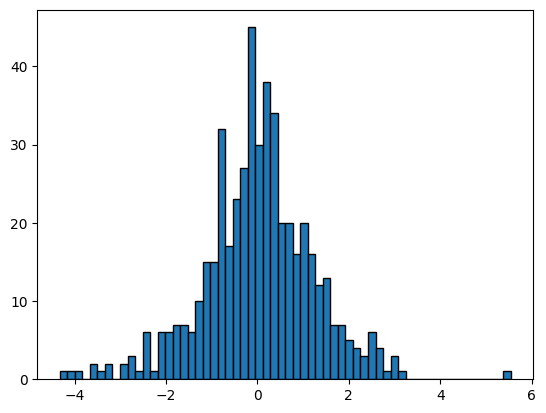

In [11]:
plt.hist(list(gf['% update ^GSPC'].values), bins=60, edgecolor='black')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
         2.,  0.,  0.,  3.,  5.,  6.,  1.,  5., 10., 11., 15., 23., 19.,
        27., 24., 29., 33., 38., 28., 35., 22., 24., 23., 19., 21., 14.,
        12., 10.,  6.,  3.,  5.,  4.,  0.,  2.,  3.,  2.,  0.,  1.,  2.,
         3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-12.32418034, -11.92432012, -11.52445991, -11.1245997 ,
        -10.72473948, -10.32487927,  -9.92501906,  -9.52515884,
         -9.12529863,  -8.72543841,  -8.3255782 ,  -7.92571799,
         -7.52585777,  -7.12599756,  -6.72613734,  -6.32627713,
         -5.92641692,  -5.5265567 ,  -5.12669649,  -4.72683627,
         -4.32697606,  -3.92711585,  -3.52725563,  -3.12739542,
         -2.72753521,  -2.32767499,  -1.92781478,  -1.52795456,
         -1.12809435,  -0.72823414,  -0.32837392,   0.07148629,
          0.47134651,   0.87120672,   1.27106693,   1.67092715,
          2.07078736,   2.47064758,   2.87050779,   3.270368  ,
          3.670228

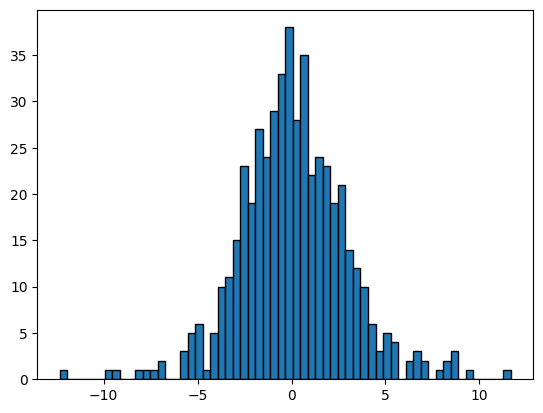

In [12]:
plt.hist(list(gf[f'% update {st}'].values), bins=60, edgecolor='black')

математическое ожидание

In [13]:
# %time snp_mat_expectation = gf['% update ^GSPC'].sum() / gf['% update ^GSPC'].value_counts().sum()
# %time snp_mat_expectation = np.average(gf['% update ^GSPC'])
snp_mat_expectation = gf['% update ^GSPC'].mean()
snp_mat_expectation

0.014010041007334212

стандартное отклонение

In [14]:
snp_standart_deviation = gf['% update ^GSPC'].std()
snp_standart_deviation

1.2260783179890318

In [15]:
snp_standart_deviation = gf[f'% update {st}'].std()
snp_standart_deviation

2.880132358990153

In [16]:
mu_z = gf['% update ^GSPC'].mean()
# se_z = gf['% update ^GSPC'].std() / sqrt(gf['% update ^GSPC'].value_counts().sum())
se_z = gf['% update ^GSPC'].std() 
z_values_snp = [(x - mu_z) / se_z for x in gf['% update ^GSPC']]

z_values_snp[:5]

[-0.011426709698539456,
 0.5662358305840319,
 0.4542729657608009,
 1.1995402882705026,
 0.43649432476494276]